In [1]:
import numpy
import matplotlib.pyplot as plt
from numpy import inf
from utils import *
from classifiers.MultivariateGaussianClassifier import *
from classifiers.NaiveBayesClassifier import *
from classifiers.TiedCovarianceGaussianClassifier import *
from classifiers.TiedDiagCovGaussianClassifier import *
from classifiers.LogisticRegression import *
from classifiers.LinearSVM import *
from classifiers.KernelSVM import *
from classifiers.GaussianMixtureModel import *
from transformers.PCA import *
from transformers.Gaussianizer import *
from tabulate import tabulate
from itertools import combinations
import time
import concurrent.futures
from tqdm import tqdm
import sklearn.model_selection
from scipy.interpolate import interp1d


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
labels_map = {
    0: 'Not a Pulsar',
    1: 'Pulsar'
}

features_map = {
    0: 'Mean of the integrated profile',
    1: 'Standard deviation of the integrated profile',
    2: 'Excess kurtosis of the integrated profile',
    3: 'Skewness of the integrated profile',
    4: 'Mean of the DM-SNR curve',
    5: 'Standard deviation of the DM-SNR curve',
    6: 'Excess kurtosis of the DM-SNR curve',
    7: 'Skewness of the DM-SNR curve'
}


In [3]:
def load_data(filepath):
    data = []
    labels = []
    with open(filepath) as f:
        for line in f:
            fields = line.split(',')
            data.append([float(feature) for feature in fields[0: 8]])
            labels.append(int(fields[8]))
    data = numpy.array(data).T  # transpose to have the features on the rows and the samples on the columns
    labels = numpy.array(labels)
    return data, labels

In [4]:
def plot_hist(D, L, folder='hist'):
    D_index_L = [D[:, L == i] for i in set(L)]

    for i in features_map.keys():
        plt.figure()
        plt.xlabel(features_map[i])
        for index, data in enumerate(D_index_L):
            plt.hist(data[i, :], bins=20, density=True, ec='black', alpha=0.5, label=labels_map[index])
        plt.legend()
        plt.tight_layout()
        plt.savefig('./plots/' + folder + '/hist_%d.png' % i)
    plt.show()


In [5]:
def plot_scatter(D, L, folder='scatter'):
    D_index_L = [D[:, L == i] for i in set(L)]

    for i in features_map.keys():
        for j in features_map.keys():
            if i == j:
                continue
            plt.figure()
            plt.xlabel(features_map[i])
            plt.ylabel(features_map[j])
            for index, data in enumerate(D_index_L):
                plt.scatter(data[i, :], data[j, :], label=labels_map[index], alpha=0.5)  # red
            plt.legend()
            plt.tight_layout()
            plt.savefig('./plots/' + folder + '/scatter_%d_%d.png' % (i, j))
        plt.show()

In [6]:
def plot_heatmap(D, folder='heatmap', subtitle='', color='YlGn'):
    corr_coef = numpy.corrcoef(D)

    fig, ax = plt.subplots()
    ax.imshow(corr_coef, cmap=color)
    for i in range(len(features_map)):
        for j in range(len(features_map)):
            ax.text(j, i, str(round(corr_coef[i, j], 1)), ha="center", va="center", color="r")

    fig.tight_layout()
    plt.savefig('./plots/' + folder + '/corr_coeff_' + subtitle + '.png')
    plt.show()

In [7]:
def compute_confusion_matrix(true, predicted):
    K = numpy.unique(numpy.concatenate((true, predicted))).size
    confusion_matrix = numpy.zeros((K, K), dtype=numpy.int64)

    # for i in range(len(true)):
    #     confusion_matrix[predicted[i], true[i]] += 1

    # 6 times speed up with respect to the previous code
    labels = numpy.hstack((vcol(predicted), vcol(true)))
    for indexes in set(combinations(tuple(list(range(K)) + list(range(K))), K)):
        equals = numpy.array(labels == indexes, dtype=numpy.int8).sum(axis=1) == K
        confusion_matrix[indexes] = numpy.array(equals, dtype=numpy.int8).sum()

    return confusion_matrix


In [8]:
def DCFu(prior, cfn, cfp, confusion_matrix):
    FNR = confusion_matrix[0, 1] / sum(confusion_matrix[:, 1])
    FPR = confusion_matrix[1, 0] / sum(confusion_matrix[:, 0])
    DCFu = prior * cfn * FNR + (1 - prior) * cfp * FPR
    return DCFu

In [9]:
def DCF(prior, cfn, cfp, confusion_matrix):
    DCFu_ = DCFu(prior, cfn, cfp, confusion_matrix)
    Bdummy = min(prior * cfn, (1 - prior) * cfp)
    return DCFu_ / Bdummy

In [10]:
def min_DCF(llr, labels, prior, cfn, cfp):
    scores = llr  # numpy.sort(llr)  # without sort improve performance

    mindcf = None
    for i, threshold in enumerate(scores):
        predicted = 0 + (llr > threshold)
        confusion_matrix_min_dcf = compute_confusion_matrix(labels, predicted)
        DCF_ = DCF(prior, cfn, cfp, confusion_matrix_min_dcf)
        mindcf = mindcf if mindcf is not None and mindcf <= DCF_ else DCF_

    return mindcf

In [23]:
def k_fold_min_DCF(D, L, K, Classifier, prior, class_args=(), transformers=[], transf_args=[]):
    if K <= 0 or K > D.shape[1]:
        raise Exception("K-Fold : K should be > 1 and <= " + str(D.shape[1]))
    nTest = int(D.shape[1] / K)
    nTrain = D.shape[1] - nTest
    numpy.random.seed(0)
    idx_1 = numpy.random.permutation(D.shape[1])
    # duplicate idx
    idx = numpy.concatenate((idx_1, idx_1))

    n_classes = len(set(L))
    llr = numpy.zeros(D.shape[1])
    for i in range(K):
        start = i * nTest
        idxTrain = idx[start: start + nTrain]
        idxTest = idx[start + nTrain: start + nTrain + nTest]

        DTR = D[:, idxTrain]
        DTE = D[:, idxTest]
        LTR = L[idxTrain]
        LTE = L[idxTest]

        for j, T in enumerate(transformers):
            transformer = T().fit(DTR, *transf_args[j])
            DTR = transformer.transform(DTR)
            DTE = transformer.transform(DTE)
        
#         print("Pre-train start")
#         start = time.perf_counter()
        classifier = Classifier(DTR, LTR, *class_args)
#         print("After-train: " + str(time.perf_counter() - start))
        llr[idxTest] = classifier.llr(DTE)

    mindcf = min_DCF(llr, L, prior, 1, 1)

    return mindcf

In [12]:
def gaussianize(D):
    return Gaussianizer().fit(D).transform(D)

In [13]:
DTR, LTR = load_data('./data/Train.txt')

# DTR, _, LTR, _ = sklearn.model_selection.train_test_split(DTR.T, LTR, train_size=1 / 8, random_state=42)
# DTR = DTR.T

In [14]:
print_plots = False
load_precomputed_data = [False, False, False, False]  # [False, False, False, False]
store_computed_data = [True, True, True, True]  # [True, True, True, True]

In [15]:
if load_precomputed_data[0]:
    DTR_G = numpy.load('./data/TrainGAU.npy')
else:
    DTR_G = Gaussianizer().fit(DTR).transform(DTR)
    if store_computed_data[0]:
        numpy.save('./data/TrainGAU.npy', DTR_G)

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:538: RuntimeWarning: invalid value encountered in multiply
  return [np.extract(cond, arr1 * expand_arr) for arr1 in newargs]


In [16]:
if print_plots:
    plot_hist(DTR, LTR)
    plot_scatter(DTR, LTR)

    plot_hist(DTR_G, LTR, folder='hist_GAU')
    plot_scatter(DTR_G, LTR, folder='scatter_GAU')

    plot_heatmap(DTR, subtitle='all', color='binary')
    plot_heatmap(DTR[:, LTR == 1], subtitle='pulsar', color='Blues')
    plot_heatmap(DTR[:, LTR == 0], subtitle='not_pulsar', color='Greens')

In [18]:
#######################################################################################
# Gaussian Models
#######################################################################################

classifier_name = numpy.array([
    'Full-Cov',
    'Diag-Cov',
    'Tied Full-Cov',
    'Tied Diag-Cov'
])
classifiers = numpy.array([
    MultivariateGaussianClassifier,
    NaiveBayesClassifier,
    TiedCovarianceGaussianClassifier,
    TiedDiagCovGaussianClassifier
])

priors = numpy.array([0.5, 0.1, 0.9])
data = [DTR for i in range(6)]
mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0]))
transformers = [
    [Gaussianizer],
    [PCA, Gaussianizer],
    [PCA, Gaussianizer],
    [PCA, Gaussianizer],
    [],
    [PCA]
]
transf_args = [
    [()],
    [(7,), ()],
    [(6,), ()],
    [(5,), ()],
    [()],
    [(7,)]
]

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incorrect")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

if load_precomputed_data[1]:
    mindcf = numpy.load('./data/minDCF_GAU_models.npy')

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[1]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p, (), transformers[d], transf_args[d])
                        future.add_done_callback(lambda _: progress.update())
                        results.append(future)
                        # print("min_DCF = " + str(mindcf[i, j]))
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d]))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if not store_computed_data[1]:
    numpy.save('./data/minDCF_GAU_models.npy', mindcf)

  0%|          | 0/12 [00:00<?, ?it/s]

Full-Cov - prior = 0.5 - data id = 0
Full-Cov - prior = 0.1 - data id = 0
Full-Cov - prior = 0.9 - data id = 0
Diag-Cov - prior = 0.5 - data id = 0
Diag-Cov - prior = 0.1 - data id = 0
Diag-Cov - prior = 0.9 - data id = 0
Tied Full-Cov - prior = 0.5 - data id = 0
Tied Full-Cov - prior = 0.1 - data id = 0
Tied Full-Cov - prior = 0.9 - data id = 0
Tied Diag-Cov - prior = 0.5 - data id = 0
Tied Diag-Cov - prior = 0.1 - data id = 0
Tied Diag-Cov - prior = 0.9 - data id = 0


  0%|          | 0/12 [00:00<?, ?it/s]

╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.154 │ 0.247 │ 0.706 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.153 │ 0.278 │ 0.606 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.131 │ 0.235 │ 0.536 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.163 │ 0.293 │ 0.611 │
╘═══════════════╧═══════╧═══════╧═══════╛
Full-Cov - prior = 0.5 - data id = 1
Full-Cov - prior = 0.1 - data id = 1
Full-Cov - prior = 0.9 - data id = 1
Diag-Cov - prior = 0.5 - data id = 1
Diag-Cov - prior = 0.1 - data id = 1
Diag-Cov - prior = 0.9 - data id = 1
Tied Full-Cov - prior = 0.5 - data id = 1
Tied Full-Cov - prior = 0.1 - data id = 1
Tied Full-Cov - prior = 0.9 - data id = 1
Tied Diag-Cov - prior = 0.5 - data id = 1
Tied Diag-Cov - prior = 0.1 - data id = 1
Tied Diag-Cov - prior = 0.9 - data id = 1


  0%|          | 0/12 [00:00<?, ?it/s]

╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.162 │ 0.427 │ 0.707 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.199 │ 0.412 │ 0.629 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.186 │ 0.3   │ 0.653 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.16  │ 0.285 │ 0.592 │
╘═══════════════╧═══════╧═══════╧═══════╛
Full-Cov - prior = 0.5 - data id = 2
Full-Cov - prior = 0.1 - data id = 2
Full-Cov - prior = 0.9 - data id = 2
Diag-Cov - prior = 0.5 - data id = 2
Diag-Cov - prior = 0.1 - data id = 2
Diag-Cov - prior = 0.9 - data id = 2
Tied Full-Cov - prior = 0.5 - data id = 2
Tied Full-Cov - prior = 0.1 - data id = 2
Tied Full-Cov - prior = 0.9 - data id = 2
Tied Diag-Cov - prior = 0.5 - data id = 2
Tied Diag-Cov - prior = 0.1 - data id = 2
Tied Diag-Cov - prior = 0.9 - data id = 2


  0%|          | 0/12 [00:00<?, ?it/s]

╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.161 │ 0.447 │ 0.697 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.2   │ 0.434 │ 0.624 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.186 │ 0.299 │ 0.651 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.162 │ 0.28  │ 0.603 │
╘═══════════════╧═══════╧═══════╧═══════╛
Full-Cov - prior = 0.5 - data id = 3
Full-Cov - prior = 0.1 - data id = 3
Full-Cov - prior = 0.9 - data id = 3
Diag-Cov - prior = 0.5 - data id = 3
Diag-Cov - prior = 0.1 - data id = 3
Diag-Cov - prior = 0.9 - data id = 3
Tied Full-Cov - prior = 0.5 - data id = 3
Tied Full-Cov - prior = 0.1 - data id = 3
Tied Full-Cov - prior = 0.9 - data id = 3
Tied Diag-Cov - prior = 0.5 - data id = 3
Tied Diag-Cov - prior = 0.1 - data id = 3
Tied Diag-Cov - prior = 0.9 - data id = 3


  0%|          | 0/12 [00:00<?, ?it/s]

╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.175 │ 0.413 │ 0.697 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.193 │ 0.378 │ 0.628 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.174 │ 0.316 │ 0.599 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.166 │ 0.297 │ 0.598 │
╘═══════════════╧═══════╧═══════╧═══════╛
Full-Cov - prior = 0.5 - data id = 4
Full-Cov - prior = 0.1 - data id = 4
Full-Cov - prior = 0.9 - data id = 4
Diag-Cov - prior = 0.5 - data id = 4
Diag-Cov - prior = 0.1 - data id = 4
Diag-Cov - prior = 0.9 - data id = 4
Tied Full-Cov - prior = 0.5 - data id = 4
Tied Full-Cov - prior = 0.1 - data id = 4
Tied Full-Cov - prior = 0.9 - data id = 4
Tied Diag-Cov - prior = 0.5 - data id = 4
Tied Diag-Cov - prior = 0.1 - data id = 4
Tied Diag-Cov - prior = 0.9 - data id = 4


  0%|          | 0/12 [00:00<?, ?it/s]

╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.141 │ 0.286 │ 0.673 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.193 │ 0.314 │ 0.747 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.112 │ 0.225 │ 0.572 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.161 │ 0.267 │ 0.58  │
╘═══════════════╧═══════╧═══════╧═══════╛
Full-Cov - prior = 0.5 - data id = 5
Full-Cov - prior = 0.1 - data id = 5
Full-Cov - prior = 0.9 - data id = 5
Diag-Cov - prior = 0.5 - data id = 5
Diag-Cov - prior = 0.1 - data id = 5
Diag-Cov - prior = 0.9 - data id = 5
Tied Full-Cov - prior = 0.5 - data id = 5
Tied Full-Cov - prior = 0.1 - data id = 5
Tied Full-Cov - prior = 0.9 - data id = 5
Tied Diag-Cov - prior = 0.5 - data id = 5
Tied Diag-Cov - prior = 0.1 - data id = 5
Tied Diag-Cov - prior = 0.9 - data id = 5


100%|██████████| 12/12 [00:14<00:00,  1.25s/it]


╒═══════════════╤═══════╤═══════╤═══════╕
│               │   0.5 │   0.1 │   0.9 │
╞═══════════════╪═══════╪═══════╪═══════╡
│ Full-Cov      │ 0.171 │ 0.299 │ 0.713 │
├───────────────┼───────┼───────┼───────┤
│ Diag-Cov      │ 0.219 │ 0.631 │ 0.821 │
├───────────────┼───────┼───────┼───────┤
│ Tied Full-Cov │ 0.152 │ 0.28  │ 0.609 │
├───────────────┼───────┼───────┼───────┤
│ Tied Diag-Cov │ 0.172 │ 0.304 │ 0.624 │
╘═══════════════╧═══════╧═══════╧═══════╛


  0%|          | 0/165 [00:00<?, ?it/s]

Log Reg - prior = 0.5 - data id = 0
Log Reg - prior = 0.1 - data id = 0
Log Reg - prior = 0.9 - data id = 0


  0%|          | 0/165 [00:00<?, ?it/s]

╒═════════╤═══════╤═══════╤═══════╕
│         │   0.5 │   0.1 │   0.9 │
╞═════════╪═══════╪═══════╪═══════╡
│ Log Reg │ 0.474 │ 0.929 │ 0.936 │
╘═════════╧═══════╧═══════╧═══════╛
Log Reg - prior = 0.5 - data id = 1
Log Reg - prior = 0.1 - data id = 1
Log Reg - prior = 0.9 - data id = 1


100%|██████████| 165/165 [03:32<00:00,  1.29s/it]


╒═════════╤═══════╤═══════╤═══════╕
│         │   0.5 │   0.1 │   0.9 │
╞═════════╪═══════╪═══════╪═══════╡
│ Log Reg │ 0.626 │     1 │  0.94 │
╘═════════╧═══════╧═══════╧═══════╛


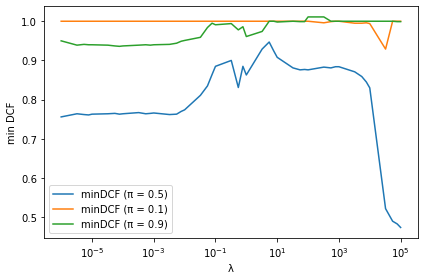

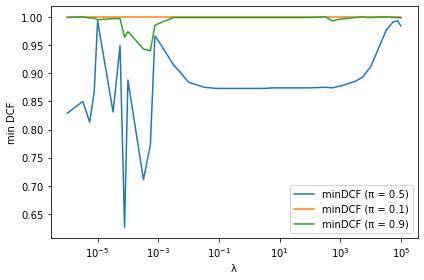

In [20]:
#######################################################################################
# Logistic Regression
#######################################################################################

classifier_name = numpy.array([
    'Log Reg'
])
classifiers = numpy.array([
    LogisticRegression
])
transformers = [
    [],
    [Gaussianizer]
]
transf_args = [
    [()],
    [()]
]
data = [DTR for i in range(2)]

lamb = numpy.array([10 ** i for i in range(-6, 6)])
lamb = numpy.array([numpy.linspace(lamb[i], lamb[i + 1], 5) for i in range(lamb.shape[0] - 1)]).reshape(-1)
priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[2]:
    mindcf = numpy.load('./data/minDCF_LogReg_lamb.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0], lamb.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[2]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0] * lamb.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        for k, l in enumerate(lamb):
                            future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p, (l,), transformers[d], transf_args[d])
                            future.add_done_callback(lambda _: progress.update())
                            results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d].min(axis=2, initial=inf)))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[2]:
    numpy.save('./data/minDCF_LogReg_lamb.npy', mindcf)

for d in range(len(data)):
    for i in range(mindcf[d].shape[0]):
        plt.figure()
        for j, p in enumerate(priors):
            plt.plot(lamb, mindcf[d, i, j], label='minDCF (π = ' + str(p) + ')')
        plt.xlabel('λ')
        plt.ylabel('min DCF')
        plt.legend()
        plt.xscale('log')
        plt.tight_layout()
        name = 'Raw' if d == 0 else 'Gaussianized'
        if store_computed_data[2]:
            plt.savefig('./plots/mindcf_training/LogReg_lamb_' + str(d) + '.png')
        plt.show()

In [ ]:
##################################################################################
# Linear SVM
##################################################################################

classifier_name = numpy.array([
    'SVM (no class balancing)',
    'SVM (with class balancing)'
])
classifiers = numpy.array([
    LinearSVM,
    LinearSVM
])
transformers = [
    [],
]
transf_args = [
    [()],
]
data = [DTR]

Ci = numpy.array([10 ** i for i in range(-3, 3)])
priors = numpy.array([0.5, 0.1, 0.9])

if load_precomputed_data[3]:
    mindcf = numpy.load('./data/minDCF_SVM_C.npy')
else:
    mindcf = numpy.zeros((len(data), classifiers.shape[0], priors.shape[0], Ci.shape[0]))

if len(data) != len(transformers) or len(transformers) != len(transf_args):
    raise Exception("Length of data/transformers/transf_args incoherent")
elif classifiers.shape[0] != classifier_name.shape[0]:
    raise Exception("Length of classifiers/classifier_name incoherent")

results = []
for d, D in enumerate(data):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        if not load_precomputed_data[3]:
            with tqdm(total=classifiers.shape[0] * priors.shape[0] * Ci.shape[0], colour='green') as progress:
                for i, c in enumerate(classifiers):
                    for j, p in enumerate(priors):
                        print(classifier_name[i] + " - prior = " + str(p) + " - data id = " + str(d))
                        for k, C in enumerate(Ci):
                            future = executor.submit(k_fold_min_DCF, D, LTR, 5, c, p, (1, C, p, None,), transformers[d], transf_args[d])
                            future.add_done_callback(lambda _: progress.update())
                            results.append(future)
                for i, r in enumerate(results):
                    mindcf[numpy.unravel_index(i, mindcf.shape, 'C')] = round(r.result(), 3)
        table = numpy.hstack((vcol(classifier_name), mindcf[d].min(axis=2, initial=inf)))
        print(tabulate(table, headers=[""] + list(priors), tablefmt='fancy_grid'))

if store_computed_data[3]:
    numpy.save('./data/minDCF_SVM_C.npy', mindcf)

for d in range(len(data)):
    for i in range(mindcf[d].shape[0]):
        plt.figure()
        for j, p in enumerate(priors):
            plt.plot(lamb, mindcf[d, i, j], label='minDCF (π = ' + str(p) + ')')
        plt.xlabel('C')
        plt.ylabel('min DCF')
        plt.legend()
        plt.xscale('log')
        plt.tight_layout()
        if store_computed_data[2]:
            plt.savefig('./plots/mindcf_training/SVM_C_' + str(d) + '_' + str(i) + '.png')
        plt.show()


  0%|          | 0/36 [00:00<?, ?it/s]

SVM (no class balancing) - prior = 0.5 - data id = 0
SVM (no class balancing) - prior = 0.1 - data id = 0
SVM (no class balancing) - prior = 0.9 - data id = 0
SVM (with class balancing) - prior = 0.5 - data id = 0
SVM (with class balancing) - prior = 0.1 - data id = 0
SVM (with class balancing) - prior = 0.9 - data id = 0
